# 算法设计：Time-Clustered GBDT (TC-GBDT)

核心思想：将时间序列数据根据拟合效果进行聚类，为每个时间簇训练专门的GBDT模型，实现时间感知的集成学习。

---

这段代码的核心思路是基于时间特征和模型拟合质量的混合聚类，实现分时段建模。主要创新点包括：

### 核心思路

#### 双重特征聚类策略

- 时间特征：提取小时、星期、月份等时间维度特征

- 拟合质量特征：通过全局模型的预测残差，计算滑动窗口内的拟合误差统计量

- 将两类特征结合进行聚类，确保同一簇内数据具有相似的时间模式和拟合特性

#### 三阶段建模流程

```python
# 阶段1：全局基准模型
global_model.fit(X, y)  # 建立整体基准

# 阶段2：特征计算与聚类
clustering_features = 时间特征 + 拟合质量特征
cluster_labels = kmeans.fit_predict(clustering_features)

# 阶段3：分簇专属建模
for cluster_id in clusters:
    cluster_model.fit(X_cluster, y_cluster)
```


#### 自适应参数调整

- 根据不同簇的拟合误差特征，动态调整模型复杂度：
    - 拟合误差大的簇 → 增加树的数量和深度

    - 提高对困难样本的建模能力

#### 预测时的智能路由

- 仅使用时间特征进行簇分类（预测时无真实值）

- 为每个样本选择对应簇的专属模型进行预测

### 技术亮点

1. 数据驱动分群：不是简单按时间分段，而是基于实际拟合效果聚类
2. 误差感知建模：识别模型拟合不佳的时段并针对性加强
3. 实用预测机制：解决了训练与预测时特征不一致的问题

这种方法特别适合具有明显时间模式且不同时段数据规律差异较大的场景。

## 代码实现

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class TimeClusteredGBDT:
    def __init__(self, n_clusters=3, base_model_params=None, time_features=['hour', 'dayofweek', 'month']):
        """
        初始化时间聚类GBDT模型
        
        Parameters:
        -----------
        n_clusters : int, 时间簇数量
        base_model_params : dict, GBDT基础模型参数
        time_features : list, 用于聚类的时间特征
        """
        self.n_clusters = n_clusters
        self.time_features = time_features
        self.cluster_models = {}
        self.cluster_centers = None
        self.kmeans = None
        self.time_kmeans = None  # 专门用于时间聚类的模型
        
        # 设置默认的GBDT参数
        if base_model_params is None:
            self.base_model_params = {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 6,
                'subsample': 0.8,
                'random_state': 42
            }
        else:
            self.base_model_params = base_model_params
    
    def _extract_time_features(self, X, timestamps):
        """
        提取时间特征
        """
        time_df = pd.DataFrame(index=range(len(timestamps)))
        time_df['timestamp'] = pd.to_datetime(timestamps)
        
        if 'hour' in self.time_features:
            time_df['hour'] = time_df['timestamp'].dt.hour
        if 'dayofweek' in self.time_features:
            time_df['dayofweek'] = time_df['timestamp'].dt.dayofweek
        if 'month' in self.time_features:
            time_df['month'] = time_df['timestamp'].dt.month
        if 'quarter' in self.time_features:
            time_df['quarter'] = time_df['timestamp'].dt.quarter
        if 'is_weekend' in self.time_features:
            time_df['is_weekend'] = (time_df['timestamp'].dt.dayofweek >= 5).astype(int)
        
        return time_df.drop('timestamp', axis=1).values
    
    def _calculate_clustering_features(self, X, y, timestamps, initial_model):
        """
        计算用于聚类的特征：时间特征 + 拟合效果特征
        """
        # 提取基础时间特征
        time_features = self._extract_time_features(X, timestamps)
        
        # 使用初始模型计算拟合效果特征
        predictions = initial_model.predict(X)
        residuals = np.abs(y - predictions)
        
        # 按时间窗口聚合拟合效果
        window_size = min(24, len(X) // 10)  # 自适应窗口大小
        fit_quality_features = []
        
        for i in range(len(X)):
            start_idx = max(0, i - window_size // 2)
            end_idx = min(len(X), i + window_size // 2 + 1)
            
            window_residuals = residuals[start_idx:end_idx]
            window_actual = y[start_idx:end_idx]
            
            # 计算多个拟合质量指标
            mae = np.mean(window_residuals)
            mape = np.mean(window_residuals / (np.abs(window_actual) + 1e-8))  # 避免除零
            std_residuals = np.std(window_residuals)
            
            fit_quality_features.append([mae, mape, std_residuals])
        
        fit_quality_features = np.array(fit_quality_features)
        
        # 组合时间特征和拟合效果特征
        clustering_features = np.hstack([time_features, fit_quality_features])
        
        return clustering_features, time_features
    
    def fit(self, X, y, timestamps):
        """
        训练时间聚类GBDT模型
        """
        # 1. 首先训练一个全局模型作为基准
        print("训练全局基准模型...")
        global_model = GradientBoostingRegressor(**self.base_model_params)
        global_model.fit(X, y)
        
        # 2. 计算聚类特征
        print("计算聚类特征...")
        clustering_features, time_features = self._calculate_clustering_features(X, y, timestamps, global_model)
        
        # 3. 时间序列聚类 - 使用完整特征进行训练
        print("进行时间聚类...")
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        cluster_labels = self.kmeans.fit_predict(clustering_features)
        self.cluster_centers = self.kmeans.cluster_centers_
        
        # 4. 专门为时间特征训练一个聚类模型用于预测
        self.time_kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        self.time_kmeans.fit(time_features)
        
        # 5. 为每个簇训练专门的GBDT模型
        print("训练簇特定模型...")
        for cluster_id in range(self.n_clusters):
            cluster_mask = cluster_labels == cluster_id
            X_cluster = X[cluster_mask]
            y_cluster = y[cluster_mask]
            
            if len(X_cluster) > 0:
                print(f"训练簇 {cluster_id} 的模型，样本数: {len(X_cluster)}")
                
                # 可以针对不同簇调整模型参数
                cluster_params = self._adapt_parameters_for_cluster(
                    cluster_id, self.base_model_params.copy()
                )
                
                cluster_model = GradientBoostingRegressor(**cluster_params)
                cluster_model.fit(X_cluster, y_cluster)
                self.cluster_models[cluster_id] = cluster_model
            else:
                print(f"警告: 簇 {cluster_id} 没有样本，使用全局模型")
                self.cluster_models[cluster_id] = global_model
        
        return self
    
    def _adapt_parameters_for_cluster(self, cluster_id, base_params):
        """
        根据不同簇的特征调整模型参数
        """
        # 基于簇中心特征调整参数
        cluster_center = self.cluster_centers[cluster_id]
        
        # 如果拟合误差较大，增加模型复杂度
        avg_mae = cluster_center[-3]  # 平均绝对误差特征
        
        if avg_mae > np.median(self.cluster_centers[:, -3]):
            base_params['n_estimators'] = int(base_params['n_estimators'] * 1.2)
            base_params['max_depth'] = min(base_params['max_depth'] + 1, 10)
        
        return base_params
    
    def predict(self, X, timestamps):
        """
        预测：根据时间特征选择对应簇的模型进行预测
        """
        if self.time_kmeans is None:
            raise ValueError("模型尚未训练，请先调用fit方法")
        
        # 提取时间特征
        time_features = self._extract_time_features(X, timestamps)
        
        # 使用时间特征进行聚类预测
        cluster_labels = self.time_kmeans.predict(time_features)
        
        predictions = np.zeros(len(X))
        
        for i, (features, cluster_id) in enumerate(zip(X, cluster_labels)):
            if cluster_id in self.cluster_models:
                predictions[i] = self.cluster_models[cluster_id].predict([features])[0]
            else:
                # 如果没有对应模型，使用第一个可用模型
                predictions[i] = list(self.cluster_models.values())[0].predict([features])[0]
        
        return predictions
    
    def evaluate_clusters(self, X, y, timestamps):
        """
        评估各簇的模型性能
        """
        time_features = self._extract_time_features(X, timestamps)
        cluster_labels = self.time_kmeans.predict(time_features)
        
        results = {}
        for cluster_id in range(self.n_clusters):
            cluster_mask = cluster_labels == cluster_id
            if np.sum(cluster_mask) > 0:
                X_cluster = X[cluster_mask]
                y_cluster = y[cluster_mask]
                
                predictions = self.cluster_models[cluster_id].predict(X_cluster)
                mse = mean_squared_error(y_cluster, predictions)
                mae = np.mean(np.abs(y_cluster - predictions))
                
                results[cluster_id] = {
                    'samples': len(X_cluster),
                    'mse': mse,
                    'mae': mae,
                    'rmse': np.sqrt(mse)
                }
        
        return results

In [6]:
class DynamicTimeWindowGBDT(TimeClusteredGBDT):
    """
    动态时间窗口GBDT：自动确定最优聚类数量和时间窗口
    """
    
    def __init__(self, max_clusters=5, min_cluster_size=0.1, **kwargs):
        super().__init__(**kwargs)
        self.max_clusters = max_clusters
        self.min_cluster_size = min_cluster_size
    
    def _find_optimal_clusters(self, clustering_features):
        """
        使用轮廓系数找到最优聚类数量
        """
        best_score = -1
        best_n_clusters = 2
        
        for n_clusters in range(2, self.max_clusters + 1):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(clustering_features)
            
            # 检查簇大小是否满足最小要求
            cluster_sizes = np.bincount(cluster_labels)
            min_size_ratio = np.min(cluster_sizes) / len(clustering_features)
            
            if min_size_ratio >= self.min_cluster_size:
                score = silhouette_score(clustering_features, cluster_labels)
                if score > best_score:
                    best_score = score
                    best_n_clusters = n_clusters
        
        print(f"最优聚类数量: {best_n_clusters}, 轮廓系数: {best_score:.3f}")
        return best_n_clusters
    
    def fit(self, X, y, timestamps):
        # 训练全局模型
        global_model = GradientBoostingRegressor(**self.base_model_params)
        global_model.fit(X, y)
        
        # 计算聚类特征（正确解包返回值）
        clustering_features, time_features = self._calculate_clustering_features(X, y, timestamps, global_model)
        
        # 动态确定最优聚类数量
        self.n_clusters = self._find_optimal_clusters(clustering_features)
        
        # 使用父类的训练逻辑
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        cluster_labels = self.kmeans.fit_predict(clustering_features)
        self.cluster_centers = self.kmeans.cluster_centers_
        
        # 专门为时间特征训练一个聚类模型用于预测（父类predict方法需要）
        self.time_kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        self.time_kmeans.fit(time_features)
        
        # 训练簇特定模型
        for cluster_id in range(self.n_clusters):
            cluster_mask = cluster_labels == cluster_id
            X_cluster = X[cluster_mask]
            y_cluster = y[cluster_mask]
            
            if len(X_cluster) > 0:
                cluster_model = GradientBoostingRegressor(**self.base_model_params)
                cluster_model.fit(X_cluster, y_cluster)
                self.cluster_models[cluster_id] = cluster_model
        
        return self

In [7]:
# 生成示例时间序列数据
def generate_sample_data(n_samples=1000):
    np.random.seed(42)
    
    # 生成时间戳
    dates = pd.date_range('2023-01-01', periods=n_samples, freq='H')
    
    # 生成特征
    X = np.random.randn(n_samples, 5)
    
    # 生成具有时间模式的目标变量
    y = np.zeros(n_samples)
    for i, date in enumerate(dates):
        hour = date.hour
        dayofweek = date.dayofweek
        
        # 不同时间段有不同的数据生成模式
        if 6 <= hour <= 18:  # 白天
            y[i] = 2 * X[i, 0] + 1.5 * X[i, 1] + np.random.normal(0, 0.5)
        else:  # 夜晚
            y[i] = 1 * X[i, 0] + 0.5 * X[i, 1] + X[i, 2] + np.random.normal(0, 0.3)
        
        # 周末效应
        if dayofweek >= 5:  # 周末
            y[i] += 0.5
    
    return X, y, dates

# 使用示例
if __name__ == "__main__":
    # 生成数据
    X, y, timestamps = generate_sample_data(2000)
    
    # 划分训练测试集
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    ts_train, ts_test = timestamps[:split_idx], timestamps[split_idx:]
    
    # 训练传统GBDT作为基准
    print("=== 传统GBDT ===")
    baseline_gbdt = GradientBoostingRegressor(n_estimators=100, random_state=42)
    baseline_gbdt.fit(X_train, y_train)
    baseline_pred = baseline_gbdt.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_pred)
    print(f"基准模型MSE: {baseline_mse:.4f}")
    
    # 训练时间聚类GBDT
    print("\n=== 时间聚类GBDT ===")
    tc_gbdt = TimeClusteredGBDT(n_clusters=3)
    tc_gbdt.fit(X_train, y_train, ts_train)
    tc_pred = tc_gbdt.predict(X_test, ts_test)
    tc_mse = mean_squared_error(y_test, tc_pred)
    print(f"时间聚类GBDT MSE: {tc_mse:.4f}")
    
    # 评估各簇性能
    cluster_results = tc_gbdt.evaluate_clusters(X_test, y_test, ts_test)
    for cluster_id, metrics in cluster_results.items():
        print(f"簇 {cluster_id}: {metrics['samples']} 样本, RMSE: {metrics['rmse']:.4f}")
    
    # 使用动态聚类
    print("\n=== 动态聚类GBDT ===")
    dynamic_gbdt = DynamicTimeWindowGBDT(max_clusters=5)
    dynamic_gbdt.fit(X_train, y_train, ts_train)
    dynamic_pred = dynamic_gbdt.predict(X_test, ts_test)
    dynamic_mse = mean_squared_error(y_test, dynamic_pred)
    print(f"动态聚类GBDT MSE: {dynamic_mse:.4f}")
    
    # 性能提升计算
    improvement = (baseline_mse - tc_mse) / baseline_mse * 100
    print(f"\n性能提升: {improvement:.2f}%")

=== 传统GBDT ===
基准模型MSE: 1.0923

=== 时间聚类GBDT ===
训练全局基准模型...
计算聚类特征...
进行时间聚类...
训练簇特定模型...
训练簇 0 的模型，样本数: 528
训练簇 1 的模型，样本数: 536
训练簇 2 的模型，样本数: 536
时间聚类GBDT MSE: 0.9293
簇 0: 136 样本, RMSE: 0.9968
簇 1: 128 样本, RMSE: 0.8178
簇 2: 136 样本, RMSE: 1.0537

=== 动态聚类GBDT ===
最优聚类数量: 2, 轮廓系数: 0.544
动态聚类GBDT MSE: 1.2233

性能提升: 14.92%


Starting visualization analysis...

1. Visualizing clustering results...


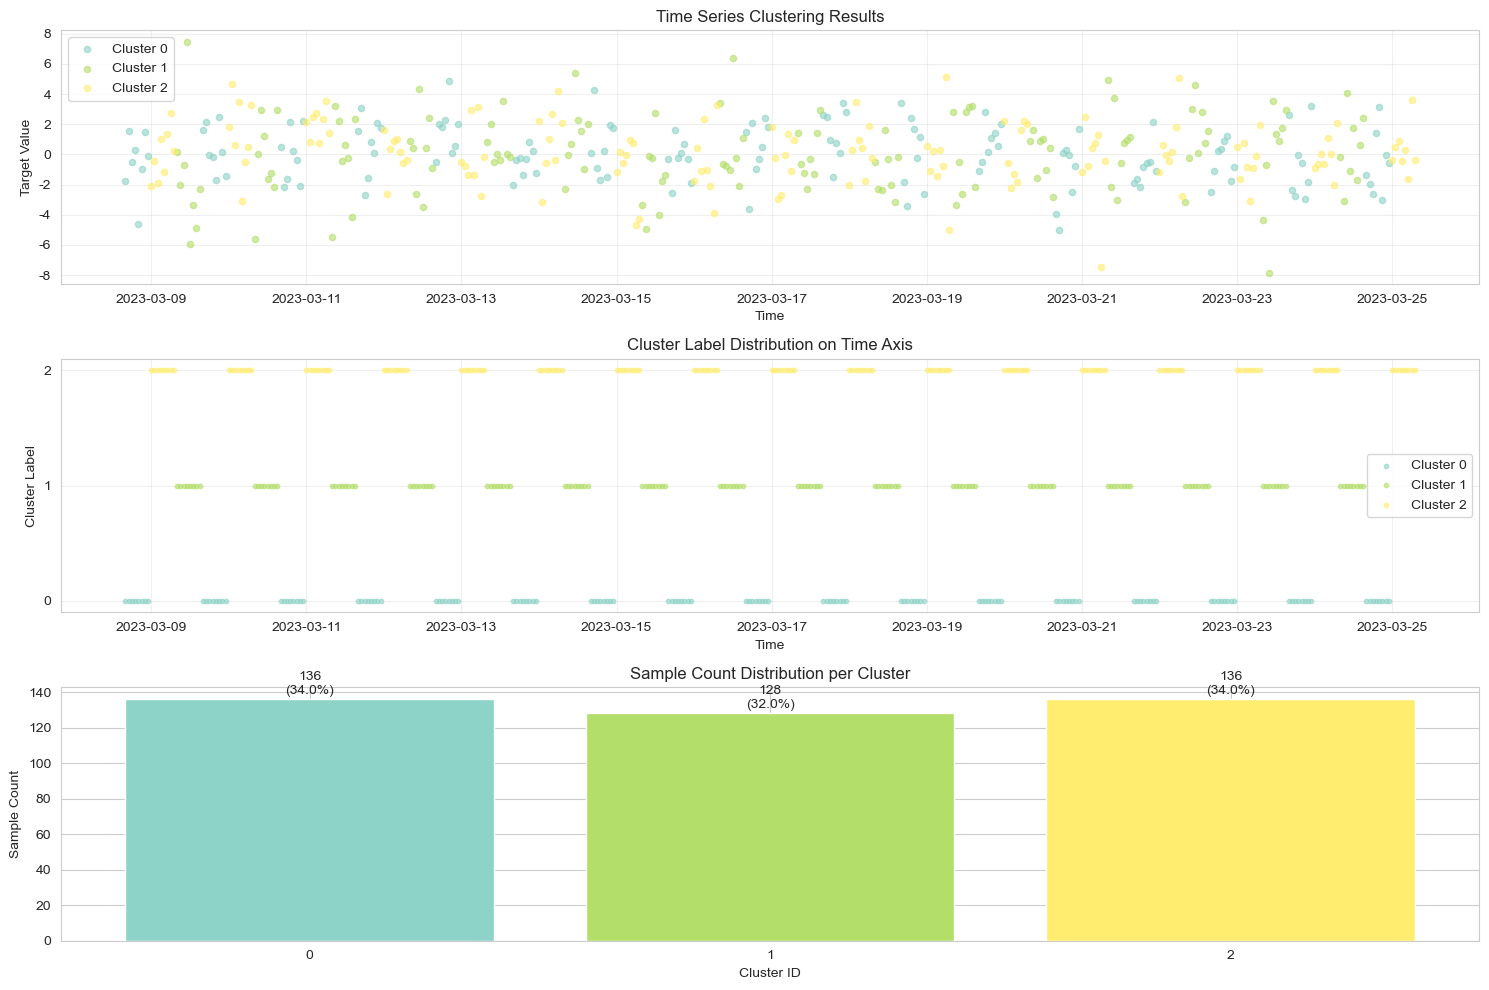


2. Visualizing prediction results...


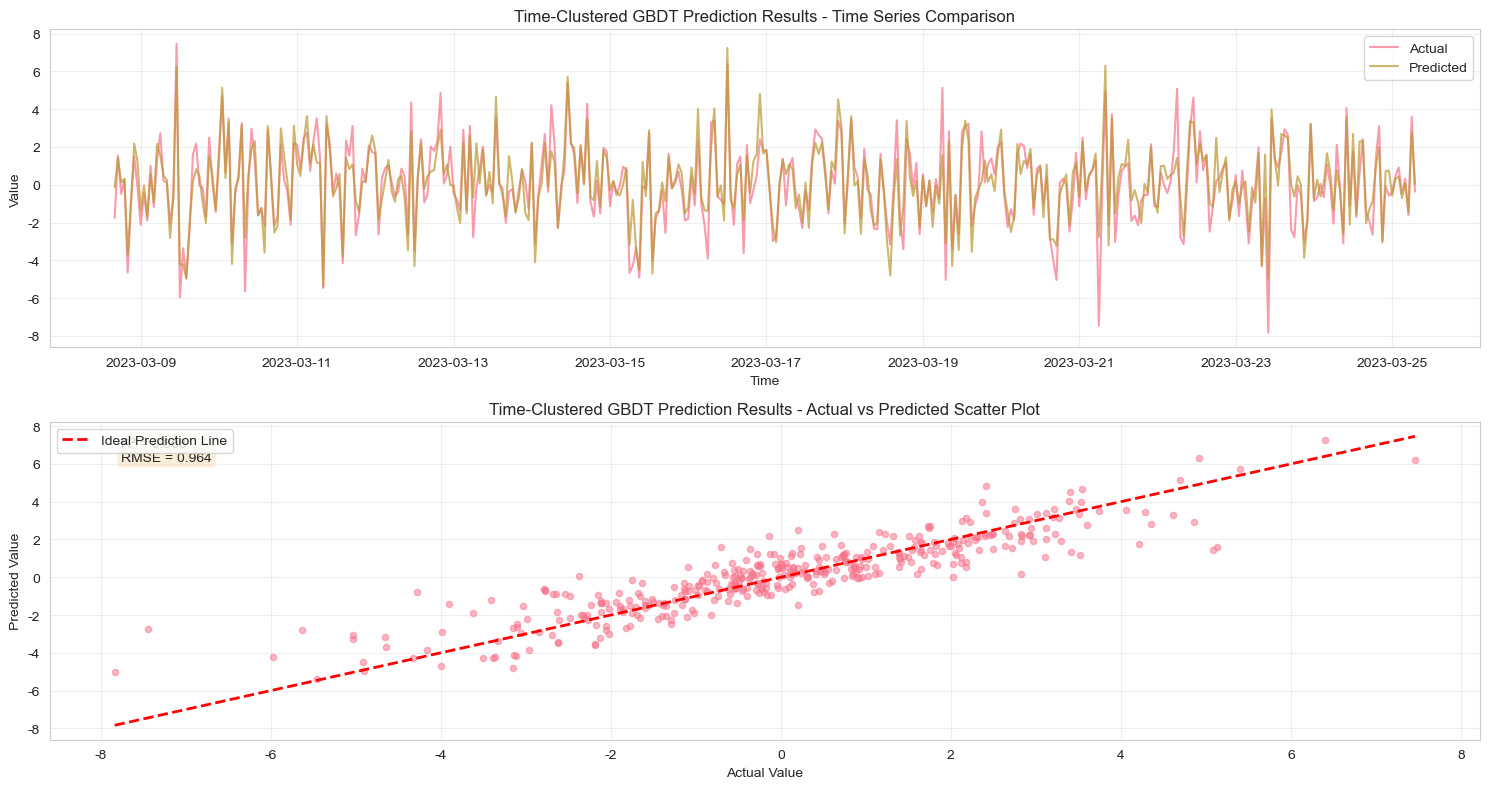


3. Visualizing cluster performance metrics...


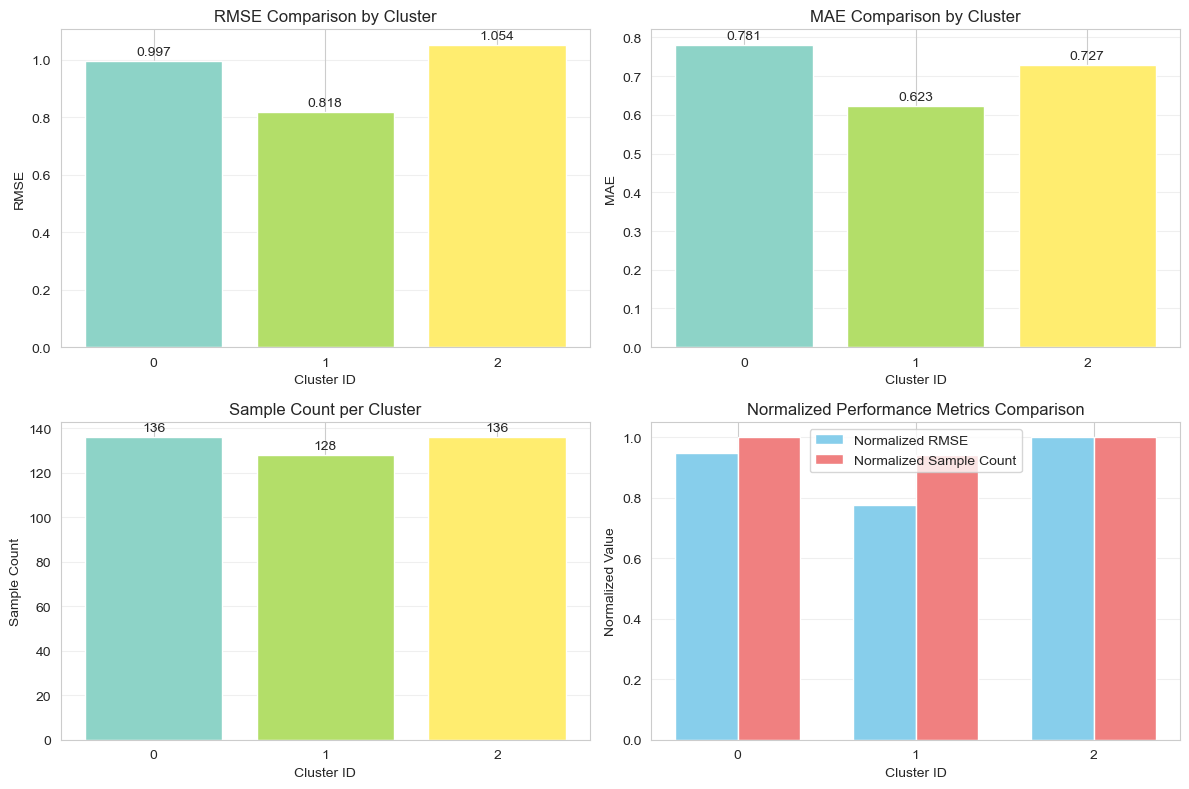


4. Visualizing cluster time distribution...


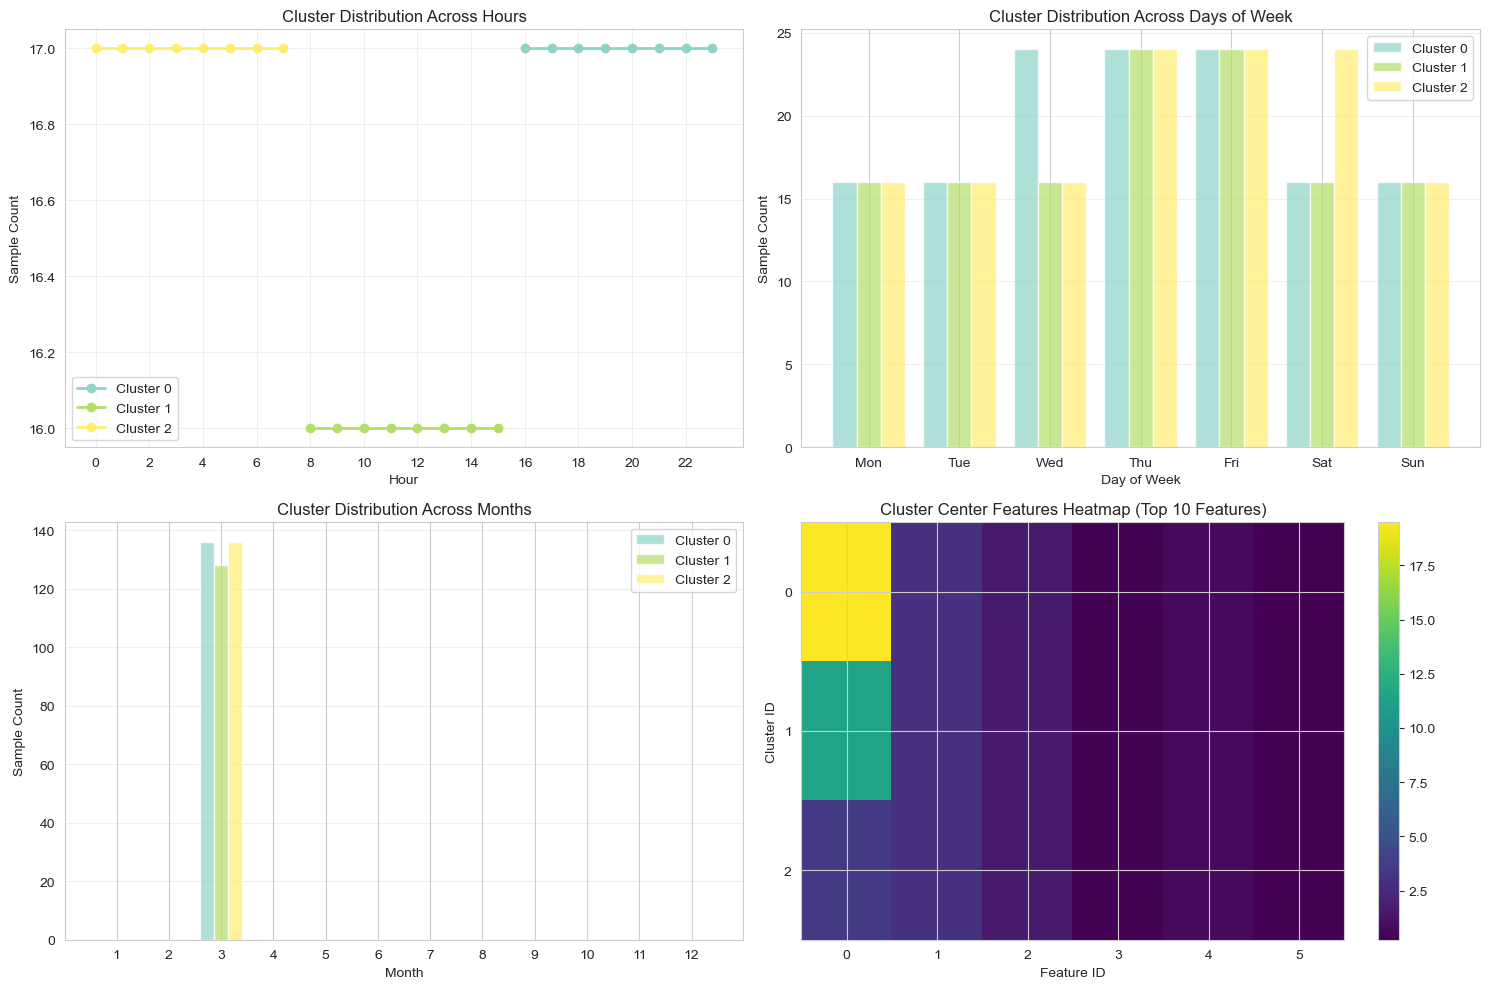


5. Visualizing residual analysis...


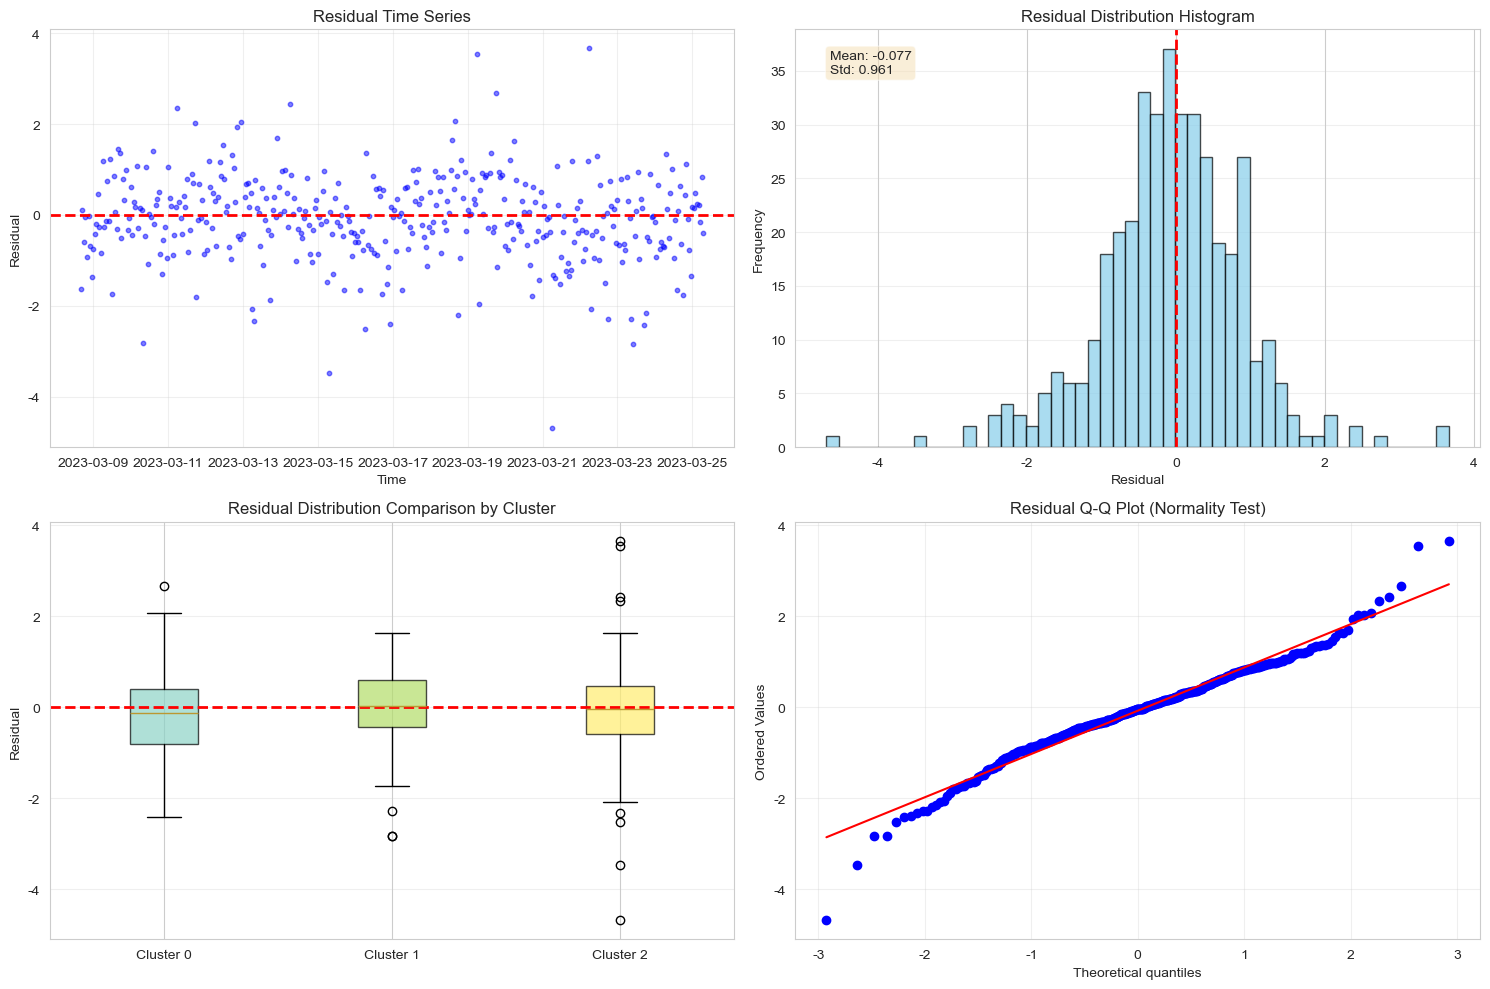


Visualization analysis completed!


In [11]:
# ========== 可视化分析示例 ==========
# 注意：运行此cell前需要先运行上面的训练代码
# 为TimeClusteredGBDT类添加可视化方法

# 设置seaborn和matplotlib中文显示
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# 设置中文字体 - seaborn使用matplotlib的字体设置
plt.rcParams['font.sans-serif'] = ['HarmonyOS Sans SC', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
rcParams['font.sans-serif'] = ['HarmonyOS Sans SC', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

# 设置seaborn样式（seaborn会自动使用matplotlib的字体设置）
sns.set_style("whitegrid")
sns.set_palette("husl")

def visualize_clustering(self, X, y, timestamps, figsize=(15, 10)):
    """Visualize clustering results: cluster distribution on time series"""
    if self.time_kmeans is None:
        raise ValueError("Model not trained yet, please call fit method first")
    
    time_features = self._extract_time_features(X, timestamps)
    cluster_labels = self.time_kmeans.predict(time_features)
    timestamps_pd = pd.to_datetime(timestamps)
    
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    colors = plt.cm.Set3(np.linspace(0, 1, self.n_clusters))
    
    # 1. Time series with cluster labels
    ax1 = axes[0]
    for cluster_id in range(self.n_clusters):
        mask = cluster_labels == cluster_id
        ax1.scatter(timestamps_pd[mask], y[mask], c=[colors[cluster_id]], 
                   label=f'Cluster {cluster_id}', alpha=0.6, s=20)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Target Value')
    ax1.set_title('Time Series Clustering Results')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Cluster label time distribution
    ax2 = axes[1]
    for cluster_id in range(self.n_clusters):
        mask = cluster_labels == cluster_id
        ax2.scatter(timestamps_pd[mask], [cluster_id] * np.sum(mask),
                   c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
                   alpha=0.6, s=10)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cluster Label')
    ax2.set_title('Cluster Label Distribution on Time Axis')
    ax2.set_yticks(range(self.n_clusters))
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Sample count per cluster
    ax3 = axes[2]
    cluster_sizes = [np.sum(cluster_labels == i) for i in range(self.n_clusters)]
    bars = ax3.bar(range(self.n_clusters), cluster_sizes, color=colors[:self.n_clusters])
    ax3.set_xlabel('Cluster ID')
    ax3.set_ylabel('Sample Count')
    ax3.set_title('Sample Count Distribution per Cluster')
    ax3.set_xticks(range(self.n_clusters))
    for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cluster_sizes)*0.01,
                f'{size}\n({size/len(X)*100:.1f}%)', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

def visualize_predictions(self, X, y, timestamps, title="Prediction Results Comparison", max_samples=500, figsize=(15, 8)):
    """Visualize prediction results: actual vs predicted values"""
    predictions = self.predict(X, timestamps)
    timestamps_pd = pd.to_datetime(timestamps)
    
    if len(X) > max_samples:
        indices = np.linspace(0, len(X)-1, max_samples, dtype=int)
        timestamps_pd = timestamps_pd[indices]
        y = y[indices]
        predictions = predictions[indices]
    
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # 1. Time series comparison
    ax1 = axes[0]
    ax1.plot(timestamps_pd, y, label='Actual', alpha=0.7, linewidth=1.5)
    ax1.plot(timestamps_pd, predictions, label='Predicted', alpha=0.7, linewidth=1.5)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.set_title(f'{title} - Time Series Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot: actual vs predicted
    ax2 = axes[1]
    ax2.scatter(y, predictions, alpha=0.5, s=20)
    min_val = min(np.min(y), np.min(predictions))
    max_val = max(np.max(y), np.max(predictions))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal Prediction Line')
    ax2.set_xlabel('Actual Value')
    ax2.set_ylabel('Predicted Value')
    ax2.set_title(f'{title} - Actual vs Predicted Scatter Plot')
    
    ss_res = np.sum((y - predictions) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    
    ax2.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}', 
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_cluster_performance(self, X, y, timestamps, figsize=(12, 8)):
    """Visualize performance metrics for each cluster"""
    results = self.evaluate_clusters(X, y, timestamps)
    time_features = self._extract_time_features(X, timestamps)
    cluster_labels = self.time_kmeans.predict(time_features)
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    colors = plt.cm.Set3(np.linspace(0, 1, self.n_clusters))
    
    cluster_ids = list(results.keys())
    samples = [results[cid]['samples'] for cid in cluster_ids]
    rmse_values = [results[cid]['rmse'] for cid in cluster_ids]
    mae_values = [results[cid]['mae'] for cid in cluster_ids]
    
    # 1. RMSE comparison
    ax1 = axes[0, 0]
    bars1 = ax1.bar(cluster_ids, rmse_values, color=colors[:len(cluster_ids)])
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('RMSE')
    ax1.set_title('RMSE Comparison by Cluster')
    ax1.set_xticks(cluster_ids)
    for bar, val in zip(bars1, rmse_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_values)*0.01,
                f'{val:.3f}', ha='center', va='bottom')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. MAE comparison
    ax2 = axes[0, 1]
    bars2 = ax2.bar(cluster_ids, mae_values, color=colors[:len(cluster_ids)])
    ax2.set_xlabel('Cluster ID')
    ax2.set_ylabel('MAE')
    ax2.set_title('MAE Comparison by Cluster')
    ax2.set_xticks(cluster_ids)
    for bar, val in zip(bars2, mae_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mae_values)*0.01,
                f'{val:.3f}', ha='center', va='bottom')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Sample count
    ax3 = axes[1, 0]
    bars3 = ax3.bar(cluster_ids, samples, color=colors[:len(cluster_ids)])
    ax3.set_xlabel('Cluster ID')
    ax3.set_ylabel('Sample Count')
    ax3.set_title('Sample Count per Cluster')
    ax3.set_xticks(cluster_ids)
    for bar, val in zip(bars3, samples):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(samples)*0.01,
                f'{val}', ha='center', va='bottom')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Normalized performance metrics comparison
    ax4 = axes[1, 1]
    norm_rmse = np.array(rmse_values) / max(rmse_values) if max(rmse_values) > 0 else np.array(rmse_values)
    norm_samples = np.array(samples) / max(samples) if max(samples) > 0 else np.array(samples)
    x = np.arange(len(cluster_ids))
    width = 0.35
    ax4.bar(x - width/2, norm_rmse, width, label='Normalized RMSE', color='skyblue')
    ax4.bar(x + width/2, norm_samples, width, label='Normalized Sample Count', color='lightcoral')
    ax4.set_xlabel('Cluster ID')
    ax4.set_ylabel('Normalized Value')
    ax4.set_title('Normalized Performance Metrics Comparison')
    ax4.set_xticks(x)
    ax4.set_xticklabels(cluster_ids)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def visualize_time_distribution(self, X, y, timestamps, figsize=(15, 10)):
    """Visualize cluster distribution across different time periods"""
    if self.time_kmeans is None:
        raise ValueError("Model not trained yet, please call fit method first")
    
    time_features = self._extract_time_features(X, timestamps)
    cluster_labels = self.time_kmeans.predict(time_features)
    timestamps_pd = pd.to_datetime(timestamps)
    
    df = pd.DataFrame({
        'timestamp': timestamps_pd,
        'cluster': cluster_labels,
        'hour': timestamps_pd.hour,
        'dayofweek': timestamps_pd.dayofweek,
        'month': timestamps_pd.month
    })
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    colors = plt.cm.Set3(np.linspace(0, 1, self.n_clusters))
    
    # 1. Cluster distribution across hours
    ax1 = axes[0, 0]
    for cluster_id in range(self.n_clusters):
        cluster_data = df[df['cluster'] == cluster_id]
        hour_counts = cluster_data['hour'].value_counts().sort_index()
        ax1.plot(hour_counts.index, hour_counts.values, 
                marker='o', label=f'Cluster {cluster_id}', color=colors[cluster_id], linewidth=2)
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Sample Count')
    ax1.set_title('Cluster Distribution Across Hours')
    ax1.set_xticks(range(0, 24, 2))
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Cluster distribution across days of week
    ax2 = axes[0, 1]
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    x = np.arange(7)
    width = 0.8 / self.n_clusters
    for i, cluster_id in enumerate(range(self.n_clusters)):
        cluster_data = df[df['cluster'] == cluster_id]
        day_counts = cluster_data['dayofweek'].value_counts().sort_index()
        day_counts_aligned = [day_counts.get(j, 0) for j in range(7)]
        ax2.bar(x + i*width, day_counts_aligned, width, 
               label=f'Cluster {cluster_id}', color=colors[cluster_id], alpha=0.7)
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Sample Count')
    ax2.set_title('Cluster Distribution Across Days of Week')
    ax2.set_xticks(x + width*(self.n_clusters-1)/2)
    ax2.set_xticklabels(day_names)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Cluster distribution across months
    ax3 = axes[1, 0]
    x = np.arange(1, 13)
    width = 0.8 / self.n_clusters
    for i, cluster_id in enumerate(range(self.n_clusters)):
        cluster_data = df[df['cluster'] == cluster_id]
        month_counts = cluster_data['month'].value_counts().sort_index()
        month_counts_aligned = [month_counts.get(j, 0) for j in range(1, 13)]
        ax3.bar(x + i*width, month_counts_aligned, width, 
               label=f'Cluster {cluster_id}', color=colors[cluster_id], alpha=0.7)
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Sample Count')
    ax3.set_title('Cluster Distribution Across Months')
    ax3.set_xticks(x + width*(self.n_clusters-1)/2)
    ax3.set_xticklabels(range(1, 13))
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Cluster center features heatmap
    ax4 = axes[1, 1]
    if self.cluster_centers is not None:
        n_features_to_show = min(10, self.cluster_centers.shape[1])
        centers_subset = self.cluster_centers[:, :n_features_to_show]
        im = ax4.imshow(centers_subset, aspect='auto', cmap='viridis')
        ax4.set_xlabel('Feature ID')
        ax4.set_ylabel('Cluster ID')
        ax4.set_title('Cluster Center Features Heatmap (Top 10 Features)')
        ax4.set_yticks(range(self.n_clusters))
        ax4.set_xticks(range(n_features_to_show))
        plt.colorbar(im, ax=ax4)
    plt.tight_layout()
    plt.show()

def visualize_residuals(self, X, y, timestamps, figsize=(15, 10)):
    """Visualize residual analysis"""
    predictions = self.predict(X, timestamps)
    residuals = y - predictions
    timestamps_pd = pd.to_datetime(timestamps)
    time_features = self._extract_time_features(X, timestamps)
    cluster_labels = self.time_kmeans.predict(time_features)
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    colors = plt.cm.Set3(np.linspace(0, 1, self.n_clusters))
    
    # 1. Residual time series
    ax1 = axes[0, 0]
    ax1.scatter(timestamps_pd, residuals, alpha=0.5, s=10, c='blue')
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Residual')
    ax1.set_title('Residual Time Series')
    ax1.grid(True, alpha=0.3)
    
    # 2. Residual distribution histogram
    ax2 = axes[0, 1]
    ax2.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Residual Distribution Histogram')
    ax2.grid(True, alpha=0.3, axis='y')
    
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    ax2.text(0.05, 0.95, f'Mean: {mean_res:.3f}\nStd: {std_res:.3f}', 
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. Residual comparison by cluster
    ax3 = axes[1, 0]
    cluster_residuals = [residuals[cluster_labels == i] for i in range(self.n_clusters)]
    bp = ax3.boxplot(cluster_residuals, labels=[f'Cluster {i}' for i in range(self.n_clusters)],
                    patch_artist=True)
    for patch, color in zip(bp['boxes'], colors[:self.n_clusters]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax3.set_ylabel('Residual')
    ax3.set_title('Residual Distribution Comparison by Cluster')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Q-Q plot (normality test)
    ax4 = axes[1, 1]
    try:
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=ax4)
        ax4.set_title('Residual Q-Q Plot (Normality Test)')
    except ImportError:
        ax4.text(0.5, 0.5, 'scipy library required for Q-Q plot', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Residual Q-Q Plot (scipy required)')
    ax4.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 将可视化方法添加到TimeClusteredGBDT类
TimeClusteredGBDT.visualize_clustering = visualize_clustering
TimeClusteredGBDT.visualize_predictions = visualize_predictions
TimeClusteredGBDT.visualize_cluster_performance = visualize_cluster_performance
TimeClusteredGBDT.visualize_time_distribution = visualize_time_distribution
TimeClusteredGBDT.visualize_residuals = visualize_residuals


print("="*50)
print("Starting visualization analysis...")
print("="*50)

# 1. Visualize clustering results
print("\n1. Visualizing clustering results...")
tc_gbdt.visualize_clustering(X_test, y_test, ts_test)

# 2. Visualize prediction results
print("\n2. Visualizing prediction results...")
tc_gbdt.visualize_predictions(X_test, y_test, ts_test, title="Time-Clustered GBDT Prediction Results")

# 3. Visualize cluster performance
print("\n3. Visualizing cluster performance metrics...")
tc_gbdt.visualize_cluster_performance(X_test, y_test, ts_test)

# 4. Visualize time distribution
print("\n4. Visualizing cluster time distribution...")
tc_gbdt.visualize_time_distribution(X_test, y_test, ts_test)

# 5. Visualize residual analysis
print("\n5. Visualizing residual analysis...")
tc_gbdt.visualize_residuals(X_test, y_test, ts_test)

print("\nVisualization analysis completed!")
